In [1]:
import pandas as pd

data = pd.read_csv("../input/taiwan-and-usa-stock-data/NVDA.csv") #NVIDIA
data = data[::-1] #invert data
data = data.reset_index()
data.head()

,index,Open,High,Low,Close,Volume
0,1258,14.76,14.87,14.69,14.72,37234400.0
1,1257,14.85,14.88,14.58,14.63,37574000.0
2,1256,14.71,14.99,14.68,14.93,68106400.0
3,1255,15.48,15.85,15.16,15.76,142574400.0
4,1254,15.78,15.88,15.53,15.75,57330400.0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   Open    1259 non-null   float64
 2   High    1259 non-null   float64
 3   Low     1259 non-null   float64
 4   Close   1259 non-null   float64
 5   Volume  1259 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 59.1 KB


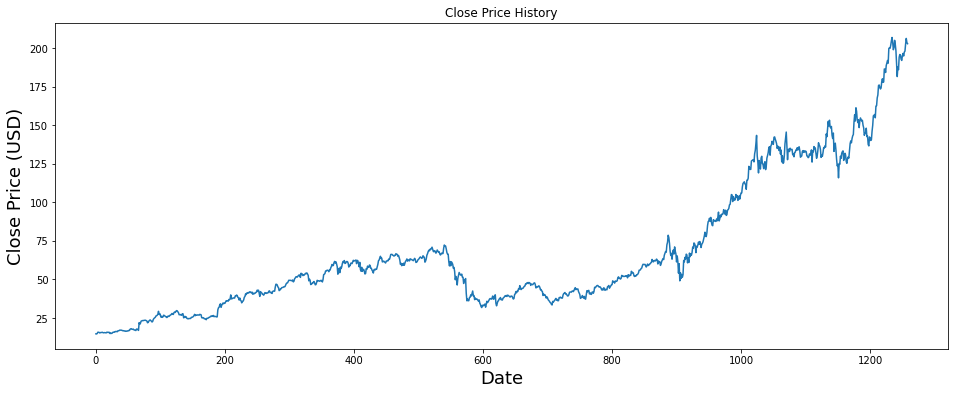

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.show()

In [4]:
pre_days = 60 # length of predicting days 
# Create a new dataframe with only the 'Close column 
data = data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(len(dataset)*.7)
validation_data_len = int(len(dataset)*0.2)
testing_data_len = len(dataset) - training_data_len - validation_data_len

print("The number of trainning dataset: ", training_data_len)
print("The number of validation dataset: ", validation_data_len)
print("The number of testing dataset: ", testing_data_len)

The number of trainning dataset:  881
The number of validation dataset:  251
The number of testing dataset:  127


In [5]:
import numpy as np
# Create the training data set 
# Create the scaled training data set
train_data = dataset[0:training_data_len, :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(pre_days, len(train_data)):
    x_train.append(train_data[i-pre_days:i, 0])
    y_train.append(train_data[i, 0])

        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

In [6]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler(feature_range=(0,1))
input_sc = scaler_x.fit(x_train)
x_train_norm = input_sc.transform(x_train)

y_train = np.reshape(y_train,(y_train.shape[0], 1))
scaler_y = MinMaxScaler(feature_range=(0,1))
output_sc = scaler_y.fit(y_train)
y_train_norm = output_sc.transform(y_train)

# Reshape the data
x_train_norm = np.reshape(x_train_norm, (x_train_norm.shape[0], x_train_norm.shape[1], 1))
print("The shape of input data: ", x_train_norm.shape)

The shape of input data:  (821, 60, 1)


In [7]:
# Create the validation data set 
# Create the scaled validation data set
val_data = dataset[training_data_len - pre_days: training_data_len + validation_data_len, :]
# Split the data into x_val and y_val data sets
x_val = []
y_val = []

for i in range(pre_days, len(val_data)):
    x_val.append(val_data[i-pre_days:i, 0])
    y_val.append(val_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays 
x_val, y_val = np.array(x_val), np.array(y_val)

In [8]:
x_val_norm = input_sc.transform(x_val)
y_val = np.reshape(y_val, (y_val.shape[0], 1))
y_val_norm = output_sc.transform(y_val)

# Reshape the data
x_val_norm = np.reshape(x_val_norm, (x_val_norm.shape[0], x_val_norm.shape[1], 1))
print("The shape of validation data: ", x_val_norm.shape)

The shape of validation data:  (251, 60, 1)


In [9]:
# test 資料集處理， label處理
# Create the testing data set 
# Create the scaled testing data set
test_data = dataset[training_data_len + validation_data_len - pre_days:, :]
# Split the data into x_test and y_test data sets
x_test = []
y_test = []

for i in range(pre_days, len(test_data)):
    x_test.append(test_data[i-pre_days:i, 0])
    y_test.append(test_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays 
x_test, y_test = np.array(x_test), np.array(y_test)

In [10]:
x_test_norm = input_sc.transform(x_test)
y_test = np.reshape(y_test, (y_test.shape[0],1))
y_test_norm = output_sc.transform(y_test)


# Reshape the data
x_test_norm = np.reshape(x_test_norm, (x_test_norm.shape[0], x_test_norm.shape[1], 1))
print("The shape of testing data: ", x_test_norm.shape)

The shape of testing data:  (127, 60, 1)


In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(200))
model.add(Dense(1))

model.summary()
print("\n")
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train_norm, y_train_norm, batch_size = 16, epochs = 20, validation_data = (x_val_norm, y_val_norm))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 200)               13000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 129,169
Trainable params: 129,169
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
52/52 [==============================] - 10s 114ms/step - loss: 0.0562 - val_loss: 0.0446
Epoch 2/20
52/52 [==============================] - 5s 87ms/step - loss: 0.0022 - val_loss: 0.0465
Epoch 3/20
52/52 [============================

In [12]:
# Get the models predicted price values 
predictions_train = model.predict(x_train_norm)
predictions_train = output_sc.inverse_transform(predictions_train)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions_train - y_train) ** 2)))
print("root mean squred error of trainning data: ", rmse)

predictions_val = model.predict(x_val_norm)
predictions_val = output_sc.inverse_transform(predictions_val)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions_val - y_val) ** 2)))
print("root mean squred error of validation data: ", rmse)

predictions_test = model.predict(x_test_norm)
predictions_test = output_sc.inverse_transform(predictions_test)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions_test - y_test) ** 2)))
print("root mean squred error of testing data: ", rmse)

root mean squred error of trainning data:  1.5318212524120451
root mean squred error of validation data:  4.369670971719721
root mean squred error of testing data:  8.161269263413718


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


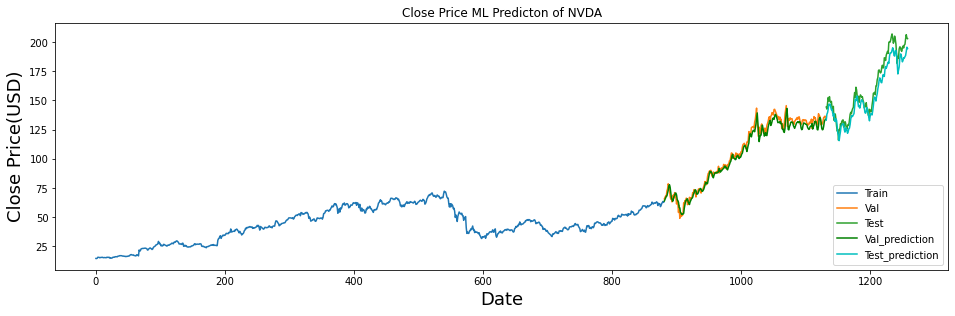

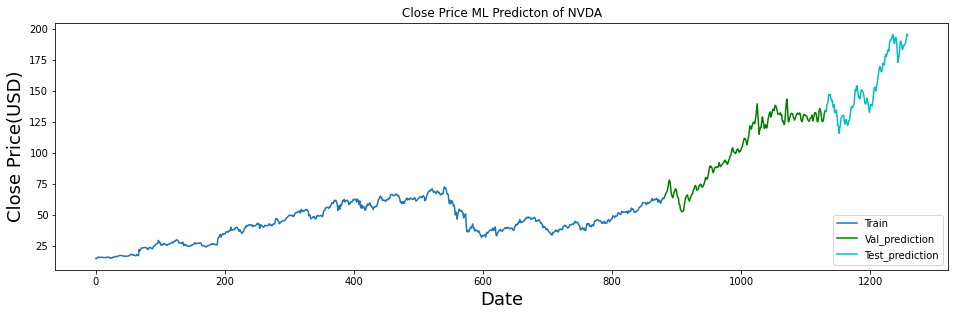

In [13]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len: training_data_len+validation_data_len]
test = data[training_data_len+validation_data_len:]
valid['Predictions'] = predictions_val
test['Predictions'] = predictions_test

# Visualize the data
plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
plt.title('Close Price ML Predicton of NVDA')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price(USD)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close' ])
plt.plot(test['Close'])
plt.plot(valid['Predictions'],color="g")
plt.plot(test['Predictions'],color="c")
plt.legend(['Train', 'Val', 'Test', 'Val_prediction', 'Test_prediction'], loc='lower right')
plt.show()


plt.figure(figsize=(16,10))
plt.subplot(2,1,2)
plt.title('Close Price ML Predicton of NVDA')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price(USD)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Predictions']],color="g")
plt.plot(test[['Predictions']],color="c")
plt.legend([ 'Train', 'Val_prediction', 'Test_prediction'], loc='lower right')
plt.show()